In [2]:
!pip3 install retentioneering

     |████████████████████████████████| 819kB 15.2MB/s 
     |████████████████████████████████| 1.3MB 15.8MB/s 
     |████████████████████████████████| 9.5MB 47.2MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 22.3MB 1.7MB/s 
     |████████████████████████████████| 1.2MB 46.5MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=fa9a81a5ccd95b9dc595ed3c2586b7d00be89939b227385d5bc2992ce2be23f9
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=b8d93ef9c4d75b1215cafcb664a454bdb863bd344ee6459a5272784d1ca6da80
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent
ERROR: retentioneering 2.0.2 has requirement matplotlib>=3.3.1, but you'll have matplotlib

In [1]:
import retentioneering
import pandas as pd
import numpy as np
import io
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import IPython

In [4]:
# from google.colab import files
# uploaded=files.upload()


ModuleNotFoundError: No module named 'google.colab'

In [2]:
# from google.colab import files
# uploaded=files.upload()

# data = pd.read_csv(io.StringIO(uploaded['mobile-app-data.csv'].decode('utf-8')),sep=',')
data = pd.read_csv('mobile-app-data.csv')

In [3]:
data.head()

,event_timestamp,event_name,user_pseudo_id
0,1554900932337794,user_engagement,c2d3a089965400c6866fc111d7ad6ec6
1,1554900932337793,first_open,c2d3a089965400c6866fc111d7ad6ec6
2,1554900913046404,basket_update,c5de1e522377a865745be3b09082aaa6
3,1554900911760484,screen_view,c5de1e522377a865745be3b09082aaa6
4,1554900911759485,user_engagement,c5de1e522377a865745be3b09082aaa6


## Подготовка данных

In [25]:
user_id = 'user_pseudo_id'
event_name = 'event_name'
map_event_name = 'map_event_name'
event_time = 'event_timestamp'


target_events = ['order'] # таргет событие

В примере использовалась старая версия библиотеки Retentioneering, поэтому немного изменяем инициализацию конфига и убираем deprecation prepare, таргеты теперь настраиваются непосредственно при вызове функции построения графика

In [45]:
retentioneering.config.update({
    'experiments_folder': 'experiments',
    'user_col': user_id,
    'event_col':event_name,
    'event_time_col':event_time,
    #'positive_target_event':'passed', # name of positive target event
    #'negative_target_event':'lost', # name of negative target event
    #'pos_target_definition':{ # how to define positive event, e.g. empty means that add passed for whom was not 'lost'
    #    'event_list':target_events
    #},
    #'neg_target_definition':{}
})

# data = data.retention.prepare()

In [11]:
# Посмотрим список всех уникальных событий
pd.set_option('display.max_rows', 1000)
print((data['event_name'].drop_duplicates()))

0                          user_engagement
1                               first_open
2                            basket_update
3                              screen_view
5             tool_click_navigation_drawer
6              tool_open_navigation_drawer
13                              chout_link
16                   basket_click_checkout
24                         phs_click_ready
27                   sys_click_back_button
28                                sys_exit
33         phs_click_ready_photo_full_size
34               phs_check_photo_full_size
37                phs_open_photo_full_size
38                         phs_check_photo
47                               os_update
54                phs_hide_selected_photos
55                        phs_select_album
56                        phs_scroll_album
59                        phs_change_album
69                       phs_change_source
71                phs_open_selected_photos
74                           session_start
77         

Получив список всех ивентов определим как их сократить для наших целей

Удаляем некоторые дефолтные события Firebase

app_clear_data  
app_exception  
app_remove  
app_update  
firebase_campaign  
os_notification_influence_open  
os_notification_opened  
os_notification_received  
os_update  
user_engagement  
sys  
session_start  
screen_view  
sys_*  
  
Объединяем  
  
auth_  
basket_  
dandd_  
ecom_  
edit_  
funnel_  
onb_  
phs_  
preview_  
prov_  
prparam_  
reg_  
sys_  
tool_  

In [37]:
def map_event(event):
    if event in ('app_clear_data', 'app_exception', 'app_remove', 'app_update', 'firebase_campaign', 
                 'os_notification_influence_open', 'os_notification_opened', 'os_notification_received', 
                 'os_update', 'user_engagement', 'sys', 'session_start', 'screen_view'):
        return None
    elif event.startswith('sys_'):
        return None
    elif event.startswith('auth_'):
        return 'auth'
    elif event.startswith('basket_'):
        return 'basket'
    elif event.startswith('dandd_'):
        return 'dandd'
    elif event.startswith('ecom_'):
        return 'ecom'
    elif event.startswith('edit_'):
        return 'edit'
    elif event.startswith('funnel_'):
        return 'funnel'
    elif event.startswith('onb_'):
        return 'onb'
    elif event.startswith('phs_'):
        return 'phs'
    elif event.startswith('preview_'):
        return 'preview'
    elif event.startswith('prov_'):
        return 'prov'
    elif event.startswith('prparam_'):
        return 'prparam'
    elif event.startswith('reg_'):
        return 'reg'
    elif event.startswith('tool_'):
        return 'tool'
    else:
        return event

In [38]:
data['map_event_name'] = list(map(map_event, data[event_name]))
data.dropna(subset=['map_event_name'], inplace=True)

In [32]:
# Посмотрим список всех уникальных событий
pd.set_option('display.max_rows', 1000)
print((data['map_event_name'].drop_duplicates()))

1                  first_open
2                      basket
5                        tool
13                 chout_link
24                        phs
27                        sys
77                        onb
91                      dandd
107                      prov
187                      edit
350                   prparam
514                   preview
759                      auth
1874                    login
2333                      reg
3319                  sign_up
4157                   funnel
9992                     ecom
10552         action_add_item
12144     action_banner_click
108398                  error
512155                  order
578036                 logout
Name: map_event_name, dtype: object


In [44]:
data.head(5)

,event_timestamp,event_name,user_pseudo_id,mapped_event,map_event_name
1,1554900932337793,first_open,c2d3a089965400c6866fc111d7ad6ec6,first_open,first_open
2,1554900913046404,basket_update,c5de1e522377a865745be3b09082aaa6,basket,basket
5,1554900911466483,tool_click_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool
6,1554900911082496,tool_open_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool
9,1554900909577687,tool_click_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool


 Посмотрим траекторию одного пользователя

In [34]:
user='c5de1e522377a865745be3b09082aaa6'
single_user_trajectory = data[data.user_pseudo_id == user]
single_user_trajectory


,event_timestamp,event_name,user_pseudo_id,mapped_event,map_event_name
2,1554900913046404,basket_update,c5de1e522377a865745be3b09082aaa6,basket,basket
5,1554900911466483,tool_click_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool
6,1554900911082496,tool_open_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool
9,1554900909577687,tool_click_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool
10,1554900909283686,tool_open_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool
11,1554900905688952,basket_update,c5de1e522377a865745be3b09082aaa6,basket,basket
40,1554900828466869,basket_update,c5de1e522377a865745be3b09082aaa6,basket,basket
43,1554900826249070,tool_click_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool
44,1554900826013069,tool_open_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool
48,1554900823967309,tool_click_navigation_drawer,c5de1e522377a865745be3b09082aaa6,tool,tool


Состав событий


### Граф

Посмотрим расположение событий в виде графа

Проверяем, что все события присутствуют, корректно отображаются. 

На данном графе мы уже можем понять как пользователи пользуются функциями приложения, для этого используем мап события

In [40]:
retentioneering.config.update({
    'event_col':map_event_name
})

data.rete.plot_graph(norm_type='full',
                     weight_col=user_id,
                     thresh=0.02,
                     targets = {'order':'green'})

'experiments/graph_2021-04-17 03_00_52_797862.html'

Так как наше целевое событие order, проанализируем как пользователь может в него прийти

1) Из dandd

2) Из prov

3) Из tool

4) Из phs

5) Из ecom

In [11]:
# Посмотрим список всех уникальных событий
pd.set_option('display.max_rows', 1000)
print((data['event_name'].drop_duplicates()))

0                          user_engagement
1                               first_open
2                            basket_update
3                              screen_view
5             tool_click_navigation_drawer
6              tool_open_navigation_drawer
13                              chout_link
16                   basket_click_checkout
24                         phs_click_ready
27                   sys_click_back_button
28                                sys_exit
33         phs_click_ready_photo_full_size
34               phs_check_photo_full_size
37                phs_open_photo_full_size
38                         phs_check_photo
47                               os_update
54                phs_hide_selected_photos
55                        phs_select_album
56                        phs_scroll_album
59                        phs_change_album
69                       phs_change_source
71                phs_open_selected_photos
74                           session_start
77         

Какие переходы между событиями есть в наших данных:

In [47]:
retentioneering.config.update({
    'event_col':event_name
})


edgelist = data.rete.get_edgelist(weight_col=user_id, edge_attributes='users_nunique')
edgelist.sort_values('users_nunique', ascending=False).head(5)

,event_name,next_event_name,users_nunique
803,first_open,onb_start_intro,17148
1642,prov_click_category,prov_click_category_product,11093
2155,tool_open_navigation_drawer,tool_click_navigation_drawer,9780
939,onb_start_intro,onb_auto_swipe,8969
929,onb_click_start,onb_auto_swipe,8915


Построим матрицу переходов пользователей между событиями (матрицу связности)

In [50]:
df=data.rete.get_adjacency(weight_col=user_id, norm_type='full')
import seaborn as sns
#from IPython.html import widgets
from IPython.display import HTML
def rotateheader():
    return  [
      #  dict(selector="th.col_heading",
    #             props=[("writing-mode", "vertical-rl"), 
     #                   ('transform', 'rotateZ(-45deg)'),
     #                   ])
     dict(selector="th", props=[("font-size", "75%"),
                            ("text-align", "right")
                         
                          ]),
        dict(selector="th.col_heading", props=[("font-size", "75%"),
                            ("text-align", "center"),
                          ("transform", "translate(0%,-140%) rotate(-15deg)")
                          ]),
             dict(selector="caption", props=[("caption-side", "bottom")])
]
 

cm = sns.light_palette("green", as_cmap=True)
print("\n\n\n")
df.style.background_gradient(cmap=cm).set_table_styles(rotateheader()).set_caption(" .")

В order чаще всего попадаем из ecom_purchase. Значит перед заказом пользователь скорее попадает в блок Ecom

### Кластеризация

Сделаем кластеризацию и оценим, на какие кластеры распадаются наши данные по конверсии

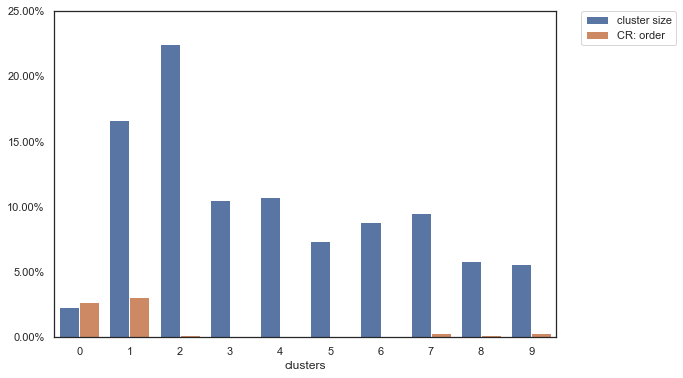

In [104]:
retentioneering.config.update({
    'event_col':map_event_name
})

data.rete.get_clusters(plot_type='cluster_bar', 
                       n_clusters=10, 
                       refit_cluster = True,
                       ngram_range=(1,2), 
                       targets=target_events);

Построим TSNE проекцию пользователей из TF-IDF пространства:

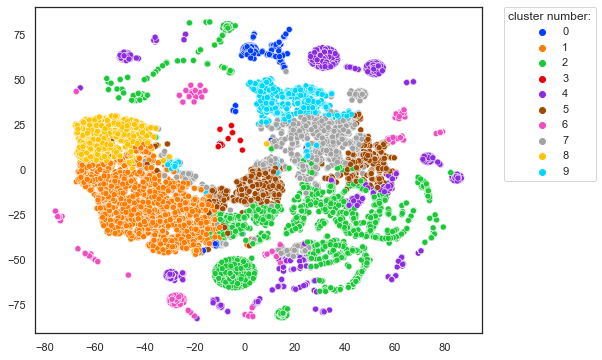

In [105]:
data.rete.project(method='tsne', plot_type='clusters');

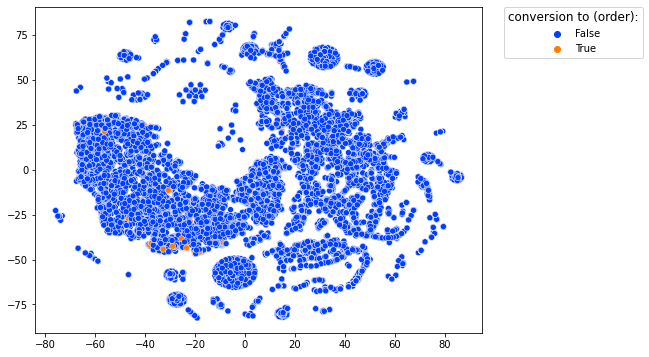

In [67]:
data.rete.project(method='tsne', plot_type='targets', targets=target_events);

Построим граф для самого конверсионного кластера:

In [68]:
retentioneering.config.update({
    'event_col':map_event_name
})

data.rete.filter_cluster(1).rete.plot_graph(norm_type='full',
                     weight_col=user_id,
                     thresh=0.02,
                     targets = {'order':'green'})

'experiments/graph_2021-04-17 03_55_13_106895.html'

Исходя из графа для кластера 1 мы понимаем что пользователь совершивший покупку пришел в Ecom через Funnel - Phs

In [69]:
data.rete.filter_cluster(0).rete.plot_graph(norm_type='full',
                     weight_col=user_id,
                     thresh=0.02,
                     targets = {'order':'green'})

'experiments/graph_2021-04-17 04_16_49_707512.html'

Исходя из графа для кластера 0 мы понимаем что пользователь совершивший покупку пришел в Ecom через Funnel - action_banner_click

Посмотрим профиль этого кластера - какие события как часто вызывались пользователями этого кластера

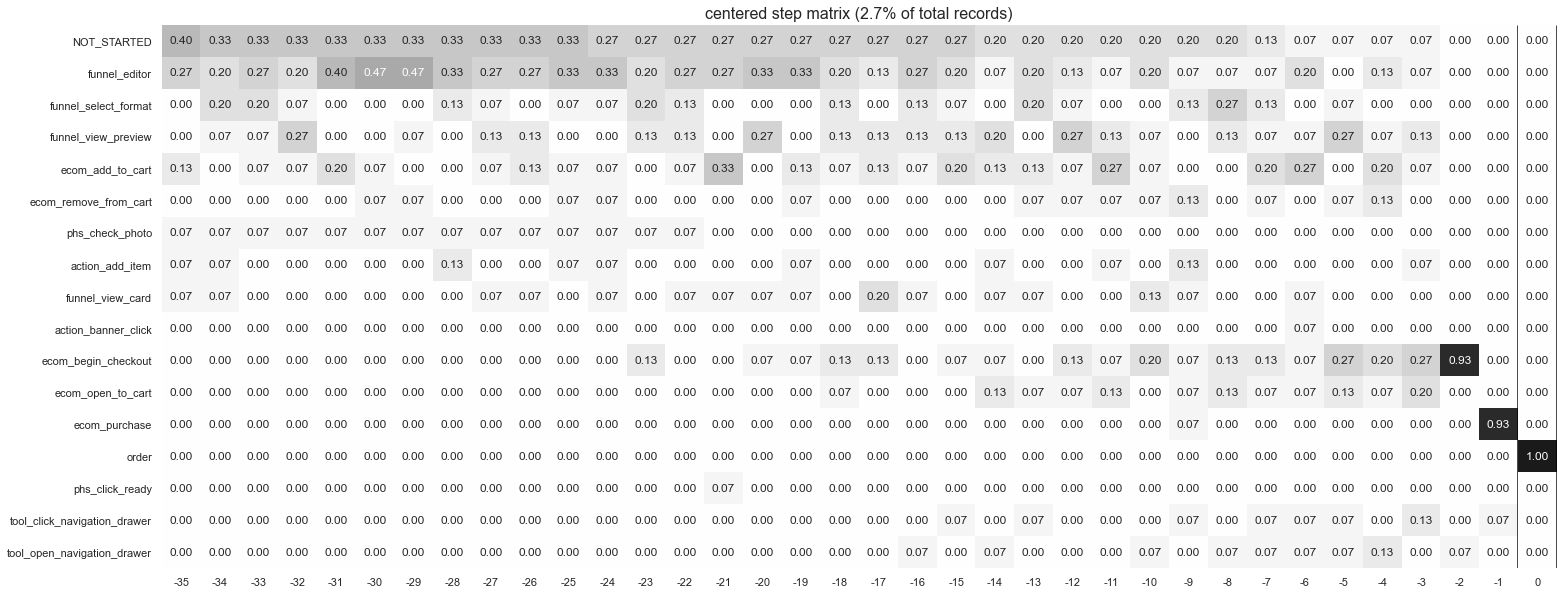

In [87]:
retentioneering.config.update({
    'event_col':event_name
})

data.rete.filter_cluster(0).rete.step_matrix(max_steps=36,
                        centered={'event': 'order',
                                  'left_gap': 35,
                                  'occurrence': 1});

Пользователи из кластера 0 активно использовали funnel_editor перед тем как совершить покупку

Сравним самый конвертируемый в покупку кластер с самым большим кластером пользователей.

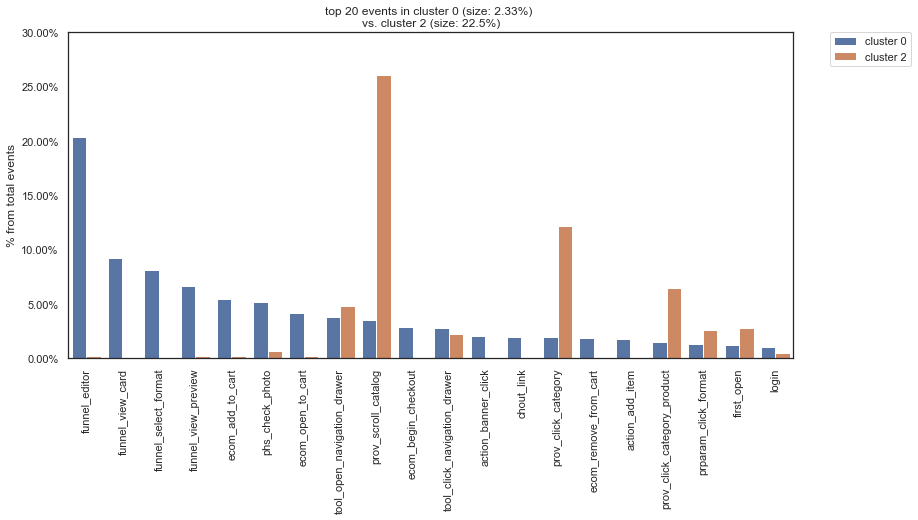

In [106]:
retentioneering.config.update({
    'event_col':event_name
})

sns.set(style='white', context='notebook', rc={'figure.figsize':(25,5)})
data.rete.cluster_event_dist(0,2, top_n=20)

Пользователеи из кластера 2 застревают на этапе каталога, тогда как пользователи из кластера 0 более целеноправлено идут по функциям приложения

### Выводы

Довольно сложно работать с clickstream ивентами когда не понимаешь что происходит) Однако удалось выделить функции приложения, понять где происходит покупка и кластеризовать пользователей по их вовлеченности в различные функции приложения. Самые целеноправленные пользователи используют Funnel, пользователей котороые смотрят каталог и мало покупают оказалось больше всего. 
